# Clean and combine COCO datasets

In [1]:
import os
import json
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(10)


### Functions

In [27]:
def get_category_counts(cct):
    '''
    Args:
        cct (dict): A COCO for Cameratraps JSON file parsed into dict

    Returns:
        Returns a dataframe in which each row includes a category and its respective
        number of annotations
    '''
    category_map = {cct['categories'][i]['id']:cct['categories'][i]['name'] for i in range(len(cct['categories']))}
    anns_df = pd.DataFrame(cct['annotations'])
    counts = anns_df.groupby(['category_id']).size().reset_index(name='counts')
    counts['category_name'] = counts['category_id'].map(category_map)
    counts_sorted = counts.sort_values(by=['counts'], ascending=False)
    return counts_sorted


def clean_cct(cct, categories, locations=None):
    '''
    Clean and filter camera trap annotations in COCO for Cameratraps format
    Filters out annotations (and corresponding images) that:
      - don't have bounding boxes
      - categories aren't included in list of selected categories
      - the bbox is too large (>95% of width OR >95% height of image)

    Args:
        cct (dict): A COCO for Cameratraps JSON file parsed into dict
        categories (list): A list of category IDs to keep
        locations (list): A list of locations to keep

    Returns:
        A tuple composed of a cleaned, filtered cct dict
        and a dict of rejects (key is reason, values are arrays of file names)
    '''
    print(f'No. annotations BEFORE cleaning: {len(cct["annotations"])}')

    image_lookup = {img['id']: img for img in cct['images']}

    anns_to_keep = []
    images_to_keep = []
    categories_to_keep = list(filter(lambda cat: cat['id'] in categories, cct['categories']))
    rejects = {
        'bad_locations': [],
        'bad_category': [],
        'no_bbox': [],
        'no_dimensions': [],
        'bbox_too_big': [],
    }

    for annotation in cct['annotations']:
        image_id = annotation['image_id']
        image = image_lookup.get(image_id)
        if image is not None:
            bbox = annotation.get('bbox')
            width, height = image.get('width'), image.get('height')
            if (locations is not None) and (image['location'] not in locations): 
                rejects['bad_locations'].append(image['file_name'])
                continue
            if annotation.get('category_id') not in categories:
                rejects['bad_category'].append(image['file_name'])
                continue
            if bbox is None or None in bbox:
                rejects['no_bbox'].append(image['file_name'])
                continue
            if width is None or height is None:
                rejects['no_dimensions'].append(image['file_name'])
                continue
            if bbox[2] >= 0.95 * width and bbox[3] >= 0.95 * height:
                rejects['bbox_too_big'].append(image['file_name'])
                continue
            anns_to_keep.append(annotation)
            images_to_keep.append(image)

    # de-dupe images (b/c images to annotations is a one-to-many relationship)
    images_df = pd.DataFrame(images_to_keep).drop_duplicates()
    images_to_keep = images_df.to_dict('records')

    print(f'No. annotations AFTER cleaning: {len(anns_to_keep)}')
    print(f'No. images AFTER cleaning: {len(images_to_keep)}')
    for reason, anns in rejects.items():
        print(f'  - {len(anns)} annotations had {reason}')

    return {
      'info': cct['info'],
      'images': images_to_keep,
      'annotations': anns_to_keep,
      'categories': categories_to_keep
    }, rejects

In [10]:
experiment = 'animl'
home_path = os.path.expanduser('~/')
raw_data_path = os.path.join(home_path, 'animl-ml/classification/data/raw')

### Animl Dataset (SCI Biosecurity)

In [12]:
animl_annotations_file = os.path.join(home_path, 'animl-ml/classification/data/raw/animl/animl_cct.json')

In [14]:
with open(animl_annotations_file, 'r') as f:
    animl = json.load(f)

In [15]:
# NOTE: category_ids are inconsistent across different coco export attempts from Animl (even from the same project)
animl_cat_counts = get_category_counts(animl)
animl_cat_counts

,category_id,counts,category_name
37,49,13573,coyote
36,47,7814,wild boar
38,50,3206,mule deer
69,91,2144,bird
64,84,2022,deer
...,...,...,...
67,89,2,bat
33,42,2,corvidae family
60,79,1,california quail
59,78,1,buff-bellied pipit


In [16]:
animl['images'][0]

{'id': '8a77fd6b36c5c65b79c6ad50aa89ccbd',
 'file_name': 'jldp/X8121117/percos_tracks/8a77fd6b36c5c65b79c6ad50aa89ccbd.jpg',
 'original_file_name': 'p_000142.jpg',
 'serving_bucket_key': 'original/8a77fd6b36c5c65b79c6ad50aa89ccbd-original.jpg',
 'datetime': '2022-10-06T22:51:18.000Z',
 'location': 'Percos Tracks'}

#### Dataset-specific cleaning
For fixing bad CCT formatting or enriching CCT 
(e.g. parsing `image['file_name']` to derive `image['location']`; modifying catefory IDs)

In [17]:
# normalize location names (strip whitespace out make lowercase)

def normalize_locations(img):
    img['location'] = img['location'].replace(' ', '_').lower()
    return img

animl['images'] = list(map(normalize_locations, animl['images']))



In [19]:
animl['categories']

[{'id': 0, 'name': 'empty'},
 {'id': 1, 'name': 'occidentalis'},
 {'id': 2, 'name': 'double-crested cormorant'},
 {'id': 3, 'name': 'snowy egret'},
 {'id': 4, 'name': "cooper's hawk"},
 {'id': 5, 'name': 'corvus species'},
 {'id': 6, 'name': 'canine family'},
 {'id': 7, 'name': 'bobcat'},
 {'id': 8, 'name': 'california gull'},
 {'id': 9, 'name': 'tringa sp'},
 {'id': 10, 'name': 'northern raccoon'},
 {'id': 11, 'name': 'grey fox'},
 {'id': 12, 'name': 'killdeer'},
 {'id': 13, 'name': 'pig'},
 {'id': 14, 'name': 'butterfly'},
 {'id': 15, 'name': 'canis species'},
 {'id': 16, 'name': 'great white egret'},
 {'id': 17, 'name': 'pelecanus species'},
 {'id': 18, 'name': 'person'},
 {'id': 19, 'name': 'long-billed curlew'},
 {'id': 20, 'name': 'american robin'},
 {'id': 21, 'name': 'greater roadrunner'},
 {'id': 22, 'name': 'brown rat'},
 {'id': 23, 'name': 'domestic dog'},
 {'id': 24, 'name': 'sus species'},
 {'id': 25, 'name': 'california towhee'},
 {'id': 26, 'name': 'california ground squ

In [28]:
# NOTE: include rats (all from NPS HQ), but make sure all NPS HQ images are NOT
# in test split (for remove-nps experiement)
animl_categories_to_keep = []
for cat in animl['categories']:
    if cat['name'] != 'person' and cat['name'] != 'animal':
        animl_categories_to_keep.append(cat['id'])

animl_clean, rejects = clean_cct(animl, animl_categories_to_keep)

No. annotations BEFORE cleaning: 38661
No. annotations AFTER cleaning: 37340
No. images AFTER cleaning: 30902
  - 0 annotations had bad_locations
  - 395 annotations had bad_category
  - 776 annotations had no_bbox
  - 0 annotations had no_dimensions
  - 150 annotations had bbox_too_big


In [29]:
# save as json file
out_file = os.path.join(home_path, f'animl-ml/classification/data/interim/{experiment}/animl_clean_cct.json')
with open(out_file, 'w') as f:
   json.dump(animl_clean, f)

### Animl Dataset (Robinson Crusoe rats)

In [9]:
buckeye_rats_file = os.path.join(home_path, 'invasive-animal-detection/data/raw/animl_buckeye_rats_cct.json')
with open(buckeye_rats_file, 'r') as f:
    buckeye_rats = json.load(f)

In [10]:
# animl CCT outputs its path in an "original_relative_path" field which is not
# part of the CCT spec, so copy those path values to "file_name" for consistency

buckeye_rats['images'] = list(map(update_file_name, buckeye_rats['images']))

In [13]:
buckeye_rats_categories_to_keep = [13]  # rats
buckeye_rats_clean, br_rejects = clean_cct(buckeye_rats, buckeye_rats_categories_to_keep)

No. annotations BEFORE cleaning: 563
No. annotations AFTER cleaning: 563
No. images AFTER cleaning: 561
  - 0 annotations had bad_locations
  - 0 annotations had bad_category
  - 0 annotations had no_bbox
  - 0 annotations had bbox_too_big


In [30]:
buckeye_rats_clean['categories']

[{'id': 17, 'name': 'rat'}]

In [31]:
# convert Robinson rat category ID ({'id': 13, 'name': 'roedor'}) to Animl's (and label from 'roedor')

for ann in buckeye_rats['annotations']:
    if ann['category_id'] == 13: # rat (RCI)
        ann['category_id'] = 17 # rat (Animl - SCI)

for cat in buckeye_rats['categories']:
    if cat['id'] == 13:
        cat['id'] = 17
        cat['name'] = 'rat'

buckeye_rats['categories']

[{'id': 0, 'name': 'empty'},
 {'id': 1, 'name': 'vaca'},
 {'id': 2, 'name': 'gato'},
 {'id': 3, 'name': 'picaflor'},
 {'id': 4, 'name': 'Zorzal'},
 {'id': 5, 'name': 'perro'},
 {'id': 6, 'name': 'vehicle'},
 {'id': 7, 'name': 'animal'},
 {'id': 8, 'name': 'caballo'},
 {'id': 9, 'name': 'pers'},
 {'id': 10, 'name': 'person'},
 {'id': 11, 'name': 'paloma'},
 {'id': 12, 'name': 'coati'},
 {'id': 17, 'name': 'rat'},
 {'id': 14, 'name': 'cone'},
 {'id': 15, 'name': 'con'},
 {'id': 16, 'name': 'cabllo'},
 {'id': 17, 'name': 'zorzal'},
 {'id': 18, 'name': 'roedr'},
 {'id': 19, 'name': 'conejo'},
 {'id': 20, 'name': 'Bird'},
 {'id': 21, 'name': 'coenjo'},
 {'id': 22, 'name': 'caballoo'},
 {'id': 23, 'name': 'CIATI'},
 {'id': 24, 'name': 'horse'},
 {'id': 25, 'name': 'cachudito'}]

### LILA Data ('rats' from Island Conservation Cameratraps dataset)

In [16]:
ic_annotations_file = os.path.join(raw_data_path, 'island_conservation.json')

In [17]:
with open(ic_annotations_file, 'r') as f:
    ic = json.load(f)

In [18]:
ic_cat_counts = get_category_counts(ic)
ic_cat_counts

,category_id,counts,category_name
0,0,77670,empty
7,7,16338,rat
22,22,8556,rabbit
21,21,6999,petrel
3,3,6284,iguana
8,8,6237,human
5,5,4737,cat
36,36,3033,goat
37,37,2588,pig
26,26,2220,shearwater


#### Dataset-specific cleaning
For fixing bad CCT formatting or enriching CCT 

e.g. parsing `image['file_name']` to derive `image['location']`

In [19]:
# parse IC's image['file_name'] to derive image['location']
for img in ic['images']:
    path = img['file_name'].split('/')[0:2]
    path = '/'.join(path)
    img['location'] = path

ic['images'][0]

{'id': 'dominicanrepublic_camara02_cam0226junio2015_dominicanrepublic_cam0226junio2015_20131026_063520_sunp0022',
 'file_name': 'dominicanrepublic/camara02/cam0226junio2015/dominicanrepublic_cam0226junio2015_20131026_063520_sunp0022.jpg',
 'width': 1280,
 'height': 1024,
 'location': 'dominicanrepublic/camara02'}

In [20]:
ic_categories_to_keep = [7, 3, 5, 37]  # rats, iguanas, cats, pigs
# from find_rat_locations.ipynb output:
ic_locations_to_keep = [
    'dominicanrepublic/camara116', 'dominicanrepublic/camara107', 
    'dominicanrepublic/camara106', 'dominicanrepublic/camara20', 
    'dominicanrepublic/camara115', 'dominicanrepublic/camara12', 
    'dominicanrepublic/camara32', 'dominicanrepublic/camara01', 
    'dominicanrepublic/camara108', 'dominicanrepublic/camara111', 
    'dominicanrepublic/camara117', 'dominicanrepublic/camara24', 
    'dominicanrepublic/camara30', 'ecuador1/ic1619', 'ecuador1/ic1616', 
    'chile/vaqueria', 'chile/frances02', 'puertorico/7a', 'puertorico/23', 
    'puertorico/2a', 'palau/cam02a', 'palau/cam09a', 'palau/cam10a', 
    'palau/cam13a', 'palau/cam14a', 'palau/cam01a', 'palau/cam04a', 
    'palau/cam06a', 'palau/cam07a', 'palau/cam08a', 'ecuador2/ic1605', 
    'ecuador2/ic1607', 'ecuador2/ic1618', 'micronesia/cam12', 
    'micronesia/cam13', 'micronesia/cam15', 'micronesia/cam03', 
    'micronesia/cam11', 'micronesia/cam10', 'micronesia/cam05', 
    'micronesia/cam08', 'micronesia/cam17', 'micronesia/cam14', 
    'micronesia/cam16', 'micronesia/cam02', 'micronesia/cam18', 
    'micronesia/cam04', 'micronesia/cam19', 'micronesia/cam06', 
    'micronesia/cam09'
]

ic_clean, rejects = clean_cct(ic, ic_categories_to_keep, ic_locations_to_keep)

No. annotations BEFORE cleaning: 142341
No. annotations AFTER cleaning: 25450
No. images AFTER cleaning: 15854
  - 71481 annotations had bad_locations
  - 45402 annotations had bad_category
  - 0 annotations had no_bbox
  - 8 annotations had bbox_too_big


In [21]:
# subsample rat samples from 'micronesia/cam06'
# 'micronesia/cam06' has 10666 rats, while the location with the second highest ammount of rat samples has 640
# the baseline model splits included micronesia/cam06 in training and seems to have learned too much about the background of that location
img_lookup = {img['id']: img for img in ic_clean['images']}

print(f'Original annotation count: {len(ic_clean["annotations"])}')

all_rat_annos_at_micronesiacam06 = []
for anno in ic_clean['annotations']:
    if anno['category_id'] == 7:
        img = img_lookup[anno['image_id']]
        if img['location'] == 'micronesia/cam06':
              all_rat_annos_at_micronesiacam06.append(anno)

print(f'Found {len(all_rat_annos_at_micronesiacam06)} rat annotations at micronesia/cam06')

subsample_annos_at_micronesiacam06 = [anno['id'] for anno in random.sample(all_rat_annos_at_micronesiacam06, 600)]
print(f'Subsample count: {len(subsample_annos_at_micronesiacam06)}')

def subsample_fn(anno):
    img = img_lookup[anno['image_id']]
    if (anno['category_id'] == 7 and 
        img['location'] == 'micronesia/cam06' and
        anno['id'] not in subsample_annos_at_micronesiacam06):
        return False
    else:
        return True     

ic_clean['annotations'] = list(filter(subsample_fn, ic_clean['annotations']))
print(f'New annotation count: {len(ic_clean["annotations"])}')

Original annotation count: 25450
Found 10667 rat annotations at micronesia/cam06
Subsample count: 600
New annotation count: 15383


In [22]:
# remove known mislabed annotations
mislabbeled_annos = [
  '5fe812fa-df31-11ea-83e9-000d3a74c7de',
  '674305e8-df31-11ea-aeb4-000d3a74c7de',
  '675ff0ae-df31-11ea-9fe3-000d3a74c7de'
]

ic_clean['annotations'] = list(filter(lambda x: x['id'] not in mislabbeled_annos, ic_clean['annotations']))

In [23]:
ic_cat_counts = get_category_counts(ic_clean)
ic_cat_counts

,category_id,counts,category_name
2,7,6268,rat
0,3,4146,iguana
1,5,3706,cat
3,37,1260,pig


In [29]:
# convert IC rat category ID to Animl's
for ann in ic_clean['annotations']:
    if ann['category_id'] == 7: # rat (IC)
        ann['category_id'] = 17 # rat (Animl)

for cat in ic_clean['categories']:
    if cat['id'] == 7:
        cat['id'] = 17

# ic_clean['annotations'][0]
ic_clean['categories']

[{'id': 3, 'name': 'iguana'},
 {'id': 5, 'name': 'cat'},
 {'id': 17, 'name': 'rat'},
 {'id': 37, 'name': 'pig'}]

### Combine datasets

In [32]:
# merge datasets into one CCT dict
coco_out = {}
coco_out['images'] = animl_clean['images'] + ic_clean['images'] + buckeye_rats_clean['images']
coco_out['annotations'] = animl_clean['annotations'] + ic_clean['annotations'] + buckeye_rats_clean['annotations']
coco_out['categories'] = animl_clean['categories'] + ic_clean['categories']+ buckeye_rats_clean['categories'] 
coco_out['categories'] = [dict(t) for t in {tuple(d.items()) for d in coco_out['categories']}] # dedupe any dupliacte classes
coco_out['info'] = animl_clean['info']

print(f'combined dataset contains {len(coco_out["annotations"])} annotations in {len(coco_out["images"])} images of the following categories: \n {list(map(lambda x: x["name"], coco_out["categories"]))}')

combined dataset contains 88001 annotations in 86588 images of the following categories: 
 ['iguana', 'scrub jay', 'bird', 'fox', 'rat', 'pig', 'lizard', 'cat', 'skunk', 'rodent']


In [33]:
coco_out['categories'] 

[{'id': 3, 'name': 'iguana'},
 {'id': 10, 'name': 'scrub jay'},
 {'id': 18, 'name': 'bird'},
 {'id': 2, 'name': 'fox'},
 {'id': 17, 'name': 'rat'},
 {'id': 37, 'name': 'pig'},
 {'id': 1, 'name': 'lizard'},
 {'id': 5, 'name': 'cat'},
 {'id': 22, 'name': 'skunk'},
 {'id': 16, 'name': 'rodent'}]

In [35]:
# sanity check
assert len(coco_out["annotations"]) == len(animl_clean["annotations"]) + len(ic_clean["annotations"]) + len(buckeye_rats_clean["annotations"])
assert len(coco_out["images"]) == len(animl_clean["images"]) + len(ic_clean["images"]) + len(buckeye_rats_clean["images"])
final_cat_counts = get_category_counts(coco_out)
final_cat_counts


,category_id,counts,category_name
5,16,31053,rodent
7,18,17080,bird
1,2,11781,fox
0,1,7902,lizard
6,17,7026,rat
2,3,4146,iguana
3,5,3706,cat
4,10,2756,scrub jay
8,22,1291,skunk
9,37,1260,pig


In [36]:
ic_clean['categories']

[{'id': 3, 'name': 'iguana'},
 {'id': 5, 'name': 'cat'},
 {'id': 17, 'name': 'rat'},
 {'id': 37, 'name': 'pig'}]

In [37]:
coco_out['categories']

[{'id': 3, 'name': 'iguana'},
 {'id': 10, 'name': 'scrub jay'},
 {'id': 18, 'name': 'bird'},
 {'id': 2, 'name': 'fox'},
 {'id': 17, 'name': 'rat'},
 {'id': 37, 'name': 'pig'},
 {'id': 1, 'name': 'lizard'},
 {'id': 5, 'name': 'cat'},
 {'id': 22, 'name': 'skunk'},
 {'id': 16, 'name': 'rodent'}]

In [38]:
final_cat_counts['counts'].sum()

88001

In [39]:
final_cat_counts['pct_of_total'] = (final_cat_counts['counts'] / final_cat_counts['counts'].sum()) * 100
final_cat_counts

,category_id,counts,category_name,pct_of_total
5,16,31053,rodent,35.287099
7,18,17080,bird,19.408870
1,2,11781,fox,13.387348
0,1,7902,lizard,8.979443
6,17,7026,rat,7.984000
2,3,4146,iguana,4.711310
3,5,3706,cat,4.211316
4,10,2756,scrub jay,3.131783
8,22,1291,skunk,1.467029
9,37,1260,pig,1.431802


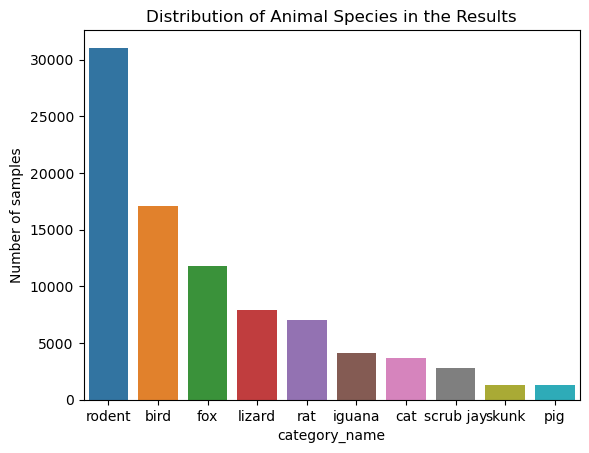

In [40]:
#plot the species distribution from the all data 
sns.barplot(data=final_cat_counts, x='category_name', y='counts')
# add labels and species numbers
# add number to each species

plt.xlabel('category_name')
plt.ylabel('Number of samples')
plt.title('Distribution of Animal Species in the Results')
plt.show()

In [41]:
# save as json file
out_file = os.path.join(home_path, f'invasive-animal-detection/data/interim/{experiment}/combined_cct.json')
with open(out_file, 'w') as f:
   json.dump(coco_out, f)
